In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error
from datetime import datetime as dt
import random
import os
import re
import xgboost as xgb
from timeit import default_timer as timer

In [6]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import svm
from sklearn.feature_selection import GenericUnivariateSelect, SelectFdr, chi2, f_classif
from sklearn.naive_bayes import GaussianNB

In [7]:
PATH=r'C:\Users\andyk\OneDrive\Documents\Python_Scripts\ATP'

def read_path(file):
    return pd.read_csv(os.path.join(PATH, file))

sm_2000_dummies=read_path("clean_matches.csv")
h2h_df=read_path("h2h_df.csv")
sm_names=read_path("sm_names.csv")
sm_perc=read_path("sm_perc.csv")
sm_diff=read_path("sm_diff.csv")
sm_h2h=read_path("sm_h2h.csv")
sm_h2h.head()

,srvwon_perc_p1,srvwon_perc_p2,retwon_perc_p1,retwon_perc_p2,bp_save_perc_p1,bp_save_perc_p2,bp_conv_perc_p1,bp_conv_perc_p2,ace_perc_p1,ace_perc_p2,...,retgames_won_perc_diff,h2h_retgames_won_perc_diff,retwon_perc_diff,h2h_retwon_perc_diff,setswon_perc_diff,h2h_setswon_perc_diff,srvgames_won_perc_diff,h2h_srvgames_won_perc_diff,srvwon_perc_diff,h2h_srvwon_perc_diff
0,0.623588,0.637299,0.387328,0.350133,0.574468,0.609929,0.360947,0.375000,0.039523,0.081672,...,0.042257,0.0,0.037196,0.0,0.163399,0.0,0.009545,0.0,-0.013711,0.0
1,0.628539,0.566176,0.383315,0.417382,0.573333,0.551724,0.365079,0.449541,0.036806,0.115546,...,-0.084082,0.0,-0.034067,0.0,0.071429,0.0,0.137192,0.0,0.062363,0.0
2,0.664962,0.635603,0.296392,0.396719,0.696970,0.622517,0.210526,0.445087,0.069054,0.060932,...,-0.138481,0.0,-0.100328,0.0,0.035714,0.0,0.158805,0.0,0.029358,0.0
3,0.604180,0.634176,0.388748,0.359868,0.566667,0.668919,0.372781,0.398438,0.076631,0.085133,...,0.085020,0.0,0.028880,0.0,0.155753,0.0,-0.010031,0.0,-0.029997,0.0
4,0.617260,0.619205,0.360193,0.383701,0.564286,0.666667,0.403226,0.415094,0.079051,0.048013,...,0.028371,0.0,-0.023508,0.0,0.059434,0.0,0.025000,0.0,-0.001946,0.0


In [8]:
sm_perc["surface"].value_counts()

Hard      12696
Clay       5973
Grass      2532
Carpet      327
Name: surface, dtype: int64

##### Stuff from the other notebook

In [9]:
RANDOM_STATE=10012020

In [10]:
other_cols=["best_of", "draw_size", "minutes", "round", "score", "surface", "tourney_level", "Year", "tournament_date"]
not_param_cols=other_cols+["Win","w_hand","l_hand","w_ioc","l_ioc", "w_seed", "l_seed", "name_p1", "name_p2"]
params=["_".join(x.split("_")[:-1]) for x in sm_names.columns[~sm_names.columns.isin(not_param_cols)]]
diff_params=[x for x in params if x not in ["hand", "ioc", "seed"]]

p1_p2_h2h_dict={param: [param+"_"+x for x in ["p1", "p2"]]+["h2h_"+param+"_"+x for x in ["p1", "p2"]] for param in params}

diff_params

['1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'ace',
 'bpFaced',
 'bpSaved',
 'df',
 'svpt',
 'age',
 'ht',
 'rank',
 'rank_points',
 '1stIn',
 '1stWon',
 '2ndWon',
 'SvGms',
 'ace',
 'bpFaced',
 'bpSaved',
 'df',
 'svpt',
 'age',
 'ht',
 'rank',
 'rank_points',
 'srv_ptswon',
 'srv_ptswon',
 'ret_pts',
 'ret_pts',
 'ret_Gms',
 'ret_Gms',
 'ret_won',
 'ret_won',
 'bp_opp',
 'bp_opp',
 'bp_conv',
 'bp_conv',
 'SvGames_won',
 'SvGames_won',
 'retgames_won',
 'retgames_won',
 'total_sets',
 'total_sets',
 'total_games',
 'total_games',
 'setswon',
 'setswon',
 'gameswon',
 'gameswon',
 'rank_log',
 'rank_log',
 'rank_points_log',
 'rank_points_log']

In [11]:
#print(sm_perc.columns)
h2h_not_params=["surface", "Date", "Win"]
h2h_diff_params=list(np.unique(["_".join(x.split("_")[:-1]) for x in sm_perc.columns[~sm_perc.columns.isin(h2h_not_params)]]))
#print(h2h_diff_params)
p1_p2_h2h_dict={param: [param+"_"+x for x in ["p1", "p2"]]+["h2h_"+param+"_"+x for x in ["p1", "p2"]] for param in h2h_diff_params}
#p1_p2_h2h_dict
h2h_params=h2h_diff_params+["h2h_"+param for param in h2h_diff_params]
diff_params=[x for x in h2h_diff_params if x not in ["name", "hand", "ioc", "seed"]]

def create_diff(df, num_cols):
    #num_cols=df.select_dtypes(include=np.number).columns.tolist()
    
    del_list=[]
    for col in num_cols:
        #get the player 1, player columns for the stat
        p1, p2, p1_h2h, p2_h2h=p1_p2_h2h_dict[col][0], p1_p2_h2h_dict[col][1], p1_p2_h2h_dict[col][2], p1_p2_h2h_dict[col][3]
        #subtract p1 and p2 stat to get differene columns
        df[col+"_diff"]=df[p1]-df[p2]
        df["h2h_"+col+"_diff"]=df[p1_h2h]-df[p2_h2h]
        del_list.extend([p1,p2, p1_h2h, p2_h2h])
    #drop all p1 and p2 columns, leaving only the difference columns
    new_df=df.drop(del_list, axis=1)
    return new_df

# Model Training

### Test Train Split

In [12]:
#print(np.shape(sm_2000_dummies["Win"]), np.shape(sm_2000_dummies.drop("Win", axis=1)))
drop_cols=["Win", "name_p1", "name_p2", "surface", "Date", "h2h_name_p1", "h2h_name_p2"]
x_train, x_test, y_train, y_test=train_test_split(sm_diff.drop(drop_cols, axis=1), 
                                                  sm_diff["Win"], 
                                                  test_size=0.3,
                                                  random_state=RANDOM_STATE)

### Scaling 

In [13]:
#normalize the data
scaler=StandardScaler()

x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)

print(np.isnan(x_train_norm).sum())
print(np.isnan(x_train).sum())

#for param in params:
#    x_train_norm.loc[:,win_lose_dict[param]].plot.hist(alpha=0.5)

0
1steff_diff                   0
h2h_1steff_diff               0
1stsrv_perc_diff              0
h2h_1stsrv_perc_diff          0
1stwin_perc_diff              0
h2h_1stwin_perc_diff          0
2ndeff_diff                   0
h2h_2ndeff_diff               0
2ndsrv_perc_diff              0
h2h_2ndsrv_perc_diff          0
2ndwin_perc_diff              0
h2h_2ndwin_perc_diff          0
ace_perc_diff                 0
h2h_ace_perc_diff             0
age_diff                      0
h2h_age_diff                  0
bp_conv_perc_diff             0
h2h_bp_conv_perc_diff         0
bp_per_retgame_diff           0
h2h_bp_per_retgame_diff       0
bp_per_svgame_diff            0
h2h_bp_per_svgame_diff        0
bp_save_perc_diff             0
h2h_bp_save_perc_diff         0
df_perc_diff                  0
h2h_df_perc_diff              0
expected_retwin_diff          0
h2h_expected_retwin_diff      0
expected_srvwin_diff          0
h2h_expected_srvwin_diff      0
gameswon_perc_diff            0
h2h_ga

## Logistic Regression

In [14]:
def coefficient_df(x_train, clf):
    return pd.DataFrame({"Feature":x_train.columns.tolist(),"Coefficients":clf.coef_[0]})

In [15]:
clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_norm, y_train)

In [16]:
y_pred=clf.predict(x_test_norm)
coef_df=coefficient_df(x_train, clf)
print(coef_df.head(50))
print(clf.score(x_test_norm, y_test))

                       Feature  Coefficients
0                  1steff_diff     -0.018411
1              h2h_1steff_diff     -0.106942
2             1stsrv_perc_diff      0.063445
3         h2h_1stsrv_perc_diff      0.017296
4             1stwin_perc_diff     -0.056176
5         h2h_1stwin_perc_diff     -0.086314
6                  2ndeff_diff      1.136019
7              h2h_2ndeff_diff     -0.241596
8             2ndsrv_perc_diff     -0.347759
9         h2h_2ndsrv_perc_diff      0.145660
10            2ndwin_perc_diff     -1.028485
11        h2h_2ndwin_perc_diff      0.116237
12               ace_perc_diff      0.011789
13           h2h_ace_perc_diff      0.009354
14                    age_diff     -0.068519
15                h2h_age_diff     -0.068519
16           bp_conv_perc_diff      0.167789
17       h2h_bp_conv_perc_diff      0.040188
18         bp_per_retgame_diff      0.100081
19     h2h_bp_per_retgame_diff     -0.630618
20          bp_per_svgame_diff     -0.769745
21      h2

In [17]:
confusion_matrix(y_test, y_pred)

array([[2347,  877],
       [ 837, 2398]], dtype=int64)

### "Lasso" (L1 penalty) Logistic

In [18]:
clf_l1=LogisticRegression(penalty="l1", solver="liblinear")\
                        .fit(x_train_norm, y_train)

In [19]:
y_pred_l1=clf_l1.predict(x_test_norm)
coef_df_l1=coefficient_df(x_train, clf_l1)
print(coef_df_l1.head(50))
print(clf_l1.score(x_test_norm, y_test))

                       Feature  Coefficients
0                  1steff_diff      0.011404
1              h2h_1steff_diff     -0.061177
2             1stsrv_perc_diff      0.056709
3         h2h_1stsrv_perc_diff      0.000000
4             1stwin_perc_diff      0.000000
5         h2h_1stwin_perc_diff     -0.057416
6                  2ndeff_diff      1.077597
7              h2h_2ndeff_diff     -0.070963
8             2ndsrv_perc_diff     -0.322945
9         h2h_2ndsrv_perc_diff      0.103447
10            2ndwin_perc_diff     -0.937010
11        h2h_2ndwin_perc_diff      0.000000
12               ace_perc_diff      0.011288
13           h2h_ace_perc_diff      0.008115
14                    age_diff     -0.136515
15                h2h_age_diff      0.000000
16           bp_conv_perc_diff      0.165656
17       h2h_bp_conv_perc_diff      0.034186
18         bp_per_retgame_diff      0.096457
19     h2h_bp_per_retgame_diff     -0.422713
20          bp_per_svgame_diff     -0.770824
21      h2

In [20]:
confusion_matrix(y_test, y_pred_l1)

array([[2343,  881],
       [ 834, 2401]], dtype=int64)

##### Run CV again, with lasso selected columns

In [21]:
sparse_index=np.where(clf_l1.coef_[0]!=0.)[0]
lasso_df=x_train_norm[:,sparse_index]
lasso_test=x_test_norm[:, sparse_index]


In [22]:
clf_l1_CV=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(lasso_df, y_train)


In [23]:
y_pred_l1_CV=clf_l1_CV.predict(lasso_test)
coef_df_l1_CV=coefficient_df(x_train.iloc[:,sparse_index], clf_l1_CV)
print(coef_df_l1_CV.head(50))
print(clf_l1_CV.score(lasso_test, y_test))

                       Feature  Coefficients
0                  1steff_diff     -0.019464
1              h2h_1steff_diff     -0.081961
2             1stsrv_perc_diff      0.080551
3         h2h_1stwin_perc_diff     -0.111113
4                  2ndeff_diff      1.154822
5              h2h_2ndeff_diff     -0.121885
6             2ndsrv_perc_diff     -0.350066
7         h2h_2ndsrv_perc_diff      0.114488
8             2ndwin_perc_diff     -1.018193
9                ace_perc_diff      0.012632
10           h2h_ace_perc_diff      0.009509
11                    age_diff     -0.136998
12           bp_conv_perc_diff      0.166519
13       h2h_bp_conv_perc_diff      0.038095
14         bp_per_retgame_diff      0.098522
15     h2h_bp_per_retgame_diff     -0.637786
16          bp_per_svgame_diff     -0.772664
17      h2h_bp_per_svgame_diff     -0.710712
18           bp_save_perc_diff      0.555878
19       h2h_bp_save_perc_diff      0.065166
20                df_perc_diff      0.140172
21        

In [24]:
confusion_matrix(y_test, y_pred_l1_CV)

array([[2346,  878],
       [ 839, 2396]], dtype=int64)

### FDR Model Selection

In [25]:
FDR=SelectFdr(f_classif, alpha=0.01)
x_train_new=FDR.fit_transform(x_train_norm, y_train)
x_test_new=FDR.transform(x_test_norm)
print(x_train.shape, x_train_new.shape)

(15069, 48) (15069, 39)


In [26]:
fdr_clf=LogisticRegressionCV(cv=5, random_state=RANDOM_STATE,
                         max_iter=4000,Cs=[1,10,100,1000])\
                        .fit(x_train_new, y_train)
fdr_pred=fdr_clf.predict(x_test_new)


In [27]:
#fdr_coef_df=coefficient_df(x_train_new, fdr_clf)
#print(fdr_coef_df.head(50))
print(fdr_clf.score(x_test_new, y_test))
confusion_matrix(y_test, fdr_pred)

0.7350983124322651


array([[2351,  873],
       [ 838, 2397]], dtype=int64)

#### ROC

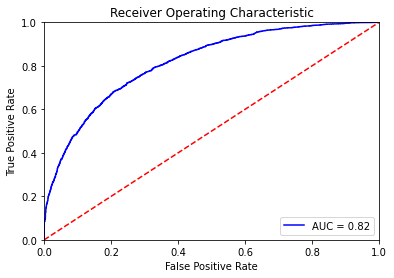

In [28]:
#predict_proba gets both predictions and probabilities
#CHECK THIS
#shamelessly stolen from stackoverflow
def ROC_plot(x_test, y_test):
    probs = clf.predict_proba(x_test)
    #print(*probs)
    preds = probs[:,1]
    #print(preds)
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
ROC_plot(x_test_norm, y_test)

#### SVM

In [ ]:
lin_svm=svm.LinearSVC().fit(x_train_norm, y_train)
svm_pred=lin_svm.predict(x_test_norm)
confusion_matrix(y_test, svm_pred)
lin_svm.score(x_test_norm, y_test)


#### Naive Bayes

In [ ]:
gnb=GaussianNB()
gnb_fit=gnb.fit(x_train_norm, y_train)
gnb_pred=gnb_fit.predict(x_test_norm)
confusion_matrix(y_test, gnb_pred)
gnb_fit.score(x_test_norm, y_test)

# Method 3 Prediction

Use a multivariate random sample with mean of the players h2h dist and cov from full columns to generate new rows. These are the predicted stats for a given match. Then, predict using the above trained models

### Mean and Covarariance

In [ ]:
num_sm_perc=sm_perc.select_dtypes(include=np.number)

cov_scaler=StandardScaler()

scaled_sm_perc=cov_scaler.fit_transform(num_sm_perc)
scaled_cov=pd.DataFrame(scaled_sm_perc, index=num_sm_perc.index, columns=num_sm_perc.columns)
scaled_cov.head()
#scaled_sm_names=pd.DataFrame(scaler.fit_transform(sm_names.loc[:, x_train.columns]), index=sm_names.index, columns=sm_names.columns)
#scaled_sm_names

In [ ]:
fixed=["ht", "age", "rank_log", "rank_points_log"]
#fixed_diff=[f+"_diff" for f in fixed]

def full_cov(df):
    p1=df.loc[:, df.columns.str.endswith("p1")]
    p2=df.loc[:, df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    print(pd.concat([p1, p2]))

    both_cov=pd.concat([p1, p2]).drop(fixed, axis=1).cov()
    
    return both_cov

covs=full_cov(scaled_cov)
covs

In [ ]:
def player_mean(player, match_df, num_matches):
    p1=match_df.loc[match_df["name_p1"]==player, match_df.columns.str.endswith("p1")]
    p2=match_df.loc[match_df["name_p2"]==player, match_df.columns.str.endswith("p2")]
    
    good_cols=["_".join(x.split("_")[:-1]) for x in list(p1.columns)]
    
    p1.columns=good_cols
    p2.columns=good_cols
    
    player_match=pd.concat([p1, p2]).drop(fixed, axis=1).sort_index()
    
    recent_mean=player_match.tail(num_matches).mean()
  
    return recent_mean

fed=player_mean("Roger Federer", sm_perc, 5)
fed

### Generate New Rows

All of the variables having univariate normal distributions suggests that assuming a multivariate normal distribution and sampling from it is justified

In [ ]:
#HEIGHTS ARENT CORRECT, LOOK AT SM_NAMES IND 98 AS EXAMPLE

def generate_new_oneplayer(player, match_df, num_matches, covs=full_cov(sm_perc)):
    means=player_mean(player, match_df, num_matches)
    
    #print(means.shape, covs.shape)
    
    new_row=pd.Series(np.random.multivariate_normal(means.values, covs), index=means.index)
    new_row["name"]=player
    #print("cols: ", match_df.columns)
    #new_row[fixed]=match_df[fixed].iloc[-1, :].values
    
    return new_row

def generate_new_row(player1, player2, match_df, num_matches):
    new_p1=generate_new_oneplayer(player1, match_df, num_matches)
    new_p2=generate_new_oneplayer(player2, match_df, num_matches)
    
    #new_p1.append(pd.Series({"fake": "faker"}))
    
    #print("new: ", new_p1)
    
    
    #print("with slicing", match_df.loc[match_df["name_p1"]==player1, [f+"_p1" for f in fixed+["name"]]].iloc[-1])
    p1_app=match_df.loc[match_df["name_p1"]==player1, [f+"_p1" for f in fixed]].iloc[-1]
    p2_app=match_df.loc[match_df["name_p2"]==player2, [f+"_p2" for f in fixed]].iloc[-1]
    
    #print("p1 app", p1_app)
    
    p1_app.index=fixed
    p2_app.index=fixed
    
    #print("p1 app", p1_app)
    
    new_p1_conc=pd.concat([new_p1, p1_app])
    new_p2_conc=pd.concat([new_p2, p2_app])
    
    #print("new p1 app", new_p1_conc)
    
    new_p1_conc.index=[c+"_p1" for c in new_p1_conc.index.tolist()]
    new_p2_conc.index=[c+"_p2" for c in new_p2_conc.index.tolist()]
    
    new_row=pd.concat([new_p1_conc, new_p2_conc])
    
    return new_row

new_row=generate_new_row("Roger Federer", "Rafael Nadal", sm_perc, 5)

#sm_names.loc[98, ["name_p1", "name_p2", "ht_p1", "ht_p2"]]

In [ ]:
test_df=pd.DataFrame({"name_p1": 
                      ["Roger Federer", "Roger Federer", "Rafael Nadal", "Stefanos Tsitsipas", "Marcos Giron", "Rafael Nadal"],
                      "name_p2": 
                      ["Novak Djokovic", "Rafael Nadal", "Roger Federer", "Alexander Zverev", "David Goffin", "Novak Djokovic"]})

In [ ]:
generated_test=test_df.apply(lambda row: generate_new_row(row["name_p1"], row["name_p2"], sm_perc, num_matches=5), axis=1)
test_df

### Add in H2H

In [ ]:
def get_h2h(player1, player2, h2h):
    #print(h2h.loc[(h2h["name_p1"]==player1)|(h2h["name_p1", :])
    try:
        most_recent=h2h.loc[((h2h["name_p1"]==player1)|(h2h["name_p1"]==player2))&((h2h["name_p2"]==player2)|(h2h["name_p2"]==player1)), :].iloc[-1, :]
        
        if most_recent["name_p1"]==player1:
            return most_recent
        elif most_recent["name_p2"]==player1:
            p1_cols=most_recent[most_recent.index.str.endswith("p1")].index.tolist()
            p2_cols=most_recent[most_recent.index.str.endswith("p2")].index.tolist()

            most_recent.loc[p1_cols+p2_cols]=most_recent.loc[p2_cols+p1_cols].values

            return most_recent
        else:
            print("something is wrong with the names of the df")

    except IndexError:
        empty_series=pd.Series(0, index=h2h.columns.tolist())
        empty_series["name_p1"]=player1
        empty_series["name_p2"]=player2
        #most_recent=pd.Series(np.zeros(shape=(len(h2h.columns.tolist()), 1)), index=h2h.columns)
        #print(empty_series)
        return empty_series
    
h2h_test=get_h2h("David Goffin", "Marcos Giron", h2h_df)
#h2h_test=test_df.apply(lambda row: get_h2h(row["name_p1"], row["name_p2"], h2h_df), axis=1)
#h2h_test
    

In [ ]:
def random_with_h2h(player1, player2, match_df, h2h, num_matches):
    random_row=generate_new_row(player1, player2, match_df, num_matches)
    h2h_row=get_h2h(player1, player2, h2h)
    #print(h2h_row)
    h2h_row.index=["h2h_"+c for c in h2h_row.index.tolist()]
    
    combined=pd.concat([random_row, h2h_row])
    
    return combined

def random_h2h_diff(new_match_df, old_match_df, h2h, num_matches):
    applied_rand_h2h=new_match_df.apply(lambda row: random_with_h2h(row["name_p1"], row["name_p2"], old_match_df, h2h, num_matches), axis=1)
    
    #print(old_match_df.loc[old_match_df["name_p1"]=="Stefanos Tsitsipas", "ht_p1"])
    #print(applied_rand_h2h[["name_p1", "name_p2", "ht_p1", "ht_p2"]])
    combined_diff=create_diff(applied_rand_h2h, diff_params)
    
    return combined_diff
    

test_rand_h2h=random_h2h_diff(test_df, sm_perc, h2h_df, num_matches=5)
test_rand_h2h

In [ ]:
def meth3_predictions(clf, new_match_df, old_match_df, h2h, num_matches):
    diffs=random_h2h_diff(new_match_df, old_match_df, h2h, num_matches)
    
    
    #print("X", x_train.columns)
    #print("rand", diffs[x_train.columns].columns)
    
    diffs_dropped=diffs[x_train.columns]
    
    diffs_dropped["h2h_ht_diff"].fillna(diffs_dropped["ht_diff"], inplace=True)
    
    #print("isna: ", diffs_dropped.isna().sum())
    #print("ht", diffs_dropped["ht_diff"])
    #print("h2hht: ", diffs_dropped["h2h_ht_diff"])
    
    #print(diffs_dropped)
    #print(diffs_dropped.shape, len(x_train.columns.tolist()), x_train_norm.shape)
    
    preds=clf.predict(diffs_dropped)
    probs=clf.predict_proba(diffs_dropped)
    
    return preds, probs, diffs

meth3_predictions(clf, test_df, sm_perc, h2h_df, num_matches=5)
    

In [ ]:
def simulate(clf, new_match_df, old_match_df, h2h, num_matches, n):
    preds=np.ones((n, new_match_df.shape[0]))
    #print(preds.shape)
    #print(preds)
    probs=np.ones((n, new_match_df.shape[0], 2))
    
    #make a diffs array and find the variance across the simulation runs for the different statistics
    for i in range(n):
        pred, prob, diffs=meth3_predictions(clf, new_match_df, old_match_df, h2h, num_matches)
        #print(pred.shape, prob.shape)
        preds[i, :]=pred
        probs[i, :, :]=prob
        #probs[i, :]=prob
    
    preds_voting=np.mean(preds, axis=0)
    probs_voting=np.mean(probs, axis=0)
    
    preds_var=np.var(preds, axis=0)
    probs_var=np.var(probs, axis=0)
    
    return preds_voting, preds_var, probs_voting, probs_var
    #return preds, preds_voting, probs, probs_voting

simulate(clf, test_df, sm_perc, h2h_df, num_matches=5, n=100)
        